# [Name] Café

*Insert brief explanation of what the situation is at the café and why we're doing a simulation.

### Imports

In [35]:
import sys
import math
import copy
import simpy
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t


### Fixed realities of the workday

The café is open for 9 hours, say 6:30 to 15:30. Two hours into the day, then starting at circa 08:30, is what one would call a "rush hour". As a baseline, the café gets around 6 customers per hour. During the rush hour, this number can rise to around 30 customers per hour.

In [36]:
HOURS_SIMULATED = 9     # The café is open for 9 hours.
RUSH_HOUR = (2,3)       # The Rush hour reaches its peak when the clock strikes {HOUR 2 OF SHIFT}. 
                        # This is where we want to experiment with adding more staff.
CLOSES = 540            # The simulation ends after those 9 hours and not a minute later.
OPEN_FOR = 525          # They'll stop serving new customers 8.75 hours in, that's 15 minutes before officially closing the shop.
                        # This should give them time to finish any orders they were working on and close up the café.

def arrival_rate(time):
    '''
    Time-varying arrival rate in customers per minute. Lambda(t).
    (Describes how frequently customers tend to arrive at each moment in time).

    We assume that a normal day at the café has:
    - A constanit baseline arrival rate of {baseline}
    - A Gaussian-shaped "rush hour" bump centered at {rush} minutes into the day.

    arrival_rate(t) = baseline + Gaussian bump
    '''

    baseline    = 6/60      # 6 customers per hour as the baseline.
    peak        = 30/60     # 30 customers per hour at peak hours.
    rush        = 120       # That's 2 hours into the day. 
    rush_length = 60        # Length of rush hour (1 hour).

    return (baseline +   (peak *   (np.exp(-((time-rush)**2) / (2*(rush_length**2))))   )   )

To better visualize this arrival rate, we've prepared a graph.

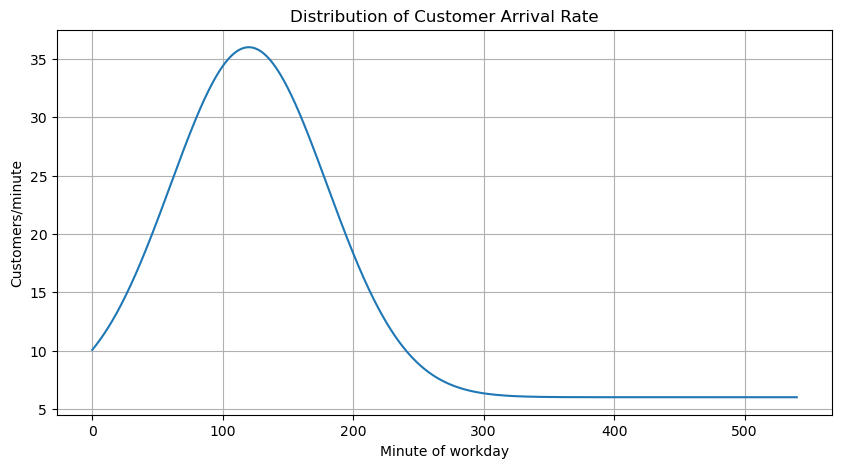

In [37]:
ttt = np.linspace(0, 540, 1000)   # 9 hours, 1000 points (smooth).

rate = (arrival_rate(ttt) * 60) # *60 since the arrival_rate returns the arrival rate in minutes. 

plt.figure(figsize=(10,5))
plt.plot(ttt, rate)
plt.xlabel("Minute of workday")
plt.ylabel("Customers/minute")
plt.title("Distribution of Customer Arrival Rate")
plt.grid(True)
plt.show()

That's the overarching arrival rate, with the rush hour peaking at around 08:30 (assuming the café opens at 6:30).

The inter-arrival rate (that is, the distribution of the time between arrivals) is exponential, with $ʎ(t)$ = arrival rate at time $t$, and mean inter-arrival time(t) = $1 / ʎ(t)$.

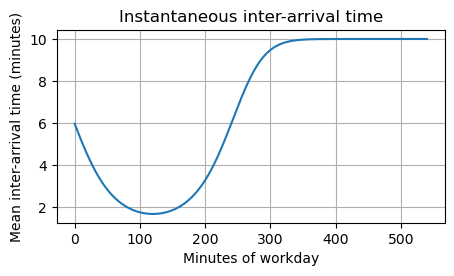

In [38]:
ttt = np.linspace(0, 540, 1000)
interarrival = 1 / arrival_rate(ttt)
plt.figure(figsize=(5,2.5)) # I made it smaller.
plt.plot(ttt, interarrival)
plt.title("Instantaneous inter-arrival time")
plt.xlabel("Minutes of workday")
plt.ylabel("Mean inter-arrival time (minutes)")
plt.grid(True)
plt.show()

This doesn't illustrate much that hasn't already been illustrated, but shows clearly that circa 10 minutes will pass on average between customers during the baseline (6 customers in 60 minutes) and circa 2 minutes will pass between customer arrivals during the worst of the rush hour. ery intuitive.

### Other Global Variables

Notably, we're normalizing everything to SimPy time units = minutes. For the sake of avoiding confusion and ensuring consistency, we will wisely also define seconds, minutes and hours in this context.

* Note that every function that returns a duration should return said value in *minutes*.

Additionally, there are some variables which should be hard-coded in the system. For example, the chance that a coffee machine needs to be utilized in order to complete an order could be something like 90%. In the same vein, the likelihood that an oven needs to be used to complete an order (to heat up a cinnamon bun, or something like that) could be 15%.

The "default variables" for simulations should also be defined here for the sake of good organization. 

The default schedule is:

|           | Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |
| --------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| Registers | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       | 1       |
| Baristas  | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       | 2       |

This is the café's current schedule, three people on site at all hours. 

The number of machines that their baristas have access to is:

| Coffee Machines | Ovens |
| --------------- | ----- |
| 1               | 1     |

The café owners have also determined that no more than 5 staff members can fit into the same shift, as there is simply not enough space behind the counter. No more than 2 of those can man the registers, as there is not enough physical space to fit more than 2 registers. This means that at maximum a shift could hold either 2 registers and 3 baristas or 1 register and 4 baristas. At minimum, a shift would need at least 1 register and 1 barista as one worker of each kind is needed for the system to function.

In [39]:
# TIME-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - -  
SECONDS = 1/60
MINUTES = 1
HOURS = 60

# LIKELIHOOD-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - - - -  
CHANCE_THAT_COFFEE_MACHINE_NEEDED = 0.9
CHANCE_THAT_OVEN_NEEDED = 0.15

# SHIFT-CONSTRAINT-RELATED GLOBALS - - - - - - - - - - - - - - - - - - - - 
NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER = 5
NUM_REGISTERS_THAT_FIT = 2

# DEFAULT NUMBER GLOBALS - - - - - - - - - - - - - - - - - - - - - - - - - 
DEFAULT_NUM_REGISTERS       = 1
DEFAULT_NUM_BARISTAS        = 2 
DEFAULT_NUM_COFFEE_MACHINES = 1 
DEFAULT_NUM_OVENS           = 1 

The concept of shifts may now be in your recent memory, as it was previously explained that the default for any shift is to have one person at the register and two persons preparing orders. It's worth elaborating on this concept of shifts, as they are one of the variables we will be playing around with.

The café's schedule is made up of shifts. To simplify things, we will make "shifts" synonymous with "hours". That means that 9 different shifts are available in the day, each an hour long. Like so:

| Hour 1 | Hour 2 | Hour 3 | Hour 4 | Hour 5 | Hour 6 | Hour 7 | Hour 8 | Hour 9 |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| Shift 1 | Shift 2 | Shift 3 | Shift 4 | Shift 5 | Shift 6 | Shift 7 | Shift 8 | Shift 9 |

The number of baristas or registers scheduled to be working can change between shifts, but the aforementioned constraints still apply to each and every one of these shifts.

* We must have at least 1 barista and 1 person at the register scheduled for each shift. This is the minimum amount of staff we need for the system to function.
* No more than 2 people can be at the register on any shift, as only 2 actual registers can fit into the space.
* No mpre than 5 people can be expected to fit behind the counter at once.

In [40]:

class Shifts:
    def __init__(self, default_num_registers=1, default_num_baristas=1):
        # TODO: Take the ones we won't use out, if we feel the need.
        '''
        The default value for each shift is 1 register and 1 barista, 
        the minimum amount of staff needed for the system to function.

        I also added easy-to-use functions to increase or decrease the count of staff in any shift.
        
        shifts.add_register_to_shift(shift=1, count=1)      --> adds 1 register to shift 1.
        shifts.add_register_to_shift(shift=1, count=2)      --> adds 2 registers to shift 1.
        shifts.remove_register_from_shift(shift=1, count=1) --> removes 1 register from shift 1.

        Each time you modify a shift, the shift automatically gets validated according to the constraints we set 
        (no more than 5 people can fit behind the counter and no more than 2 registers can fit in the space).
        If the shift is not valid, the function will return False.
        If it's valid, then it'll return True and you're free to move on.
        '''

        # If the inputs weren't valid, we return an error.
        validate_inputs = [default_num_registers, default_num_baristas]
        if not self._validate_shift(validate_inputs):
            raise ValueError(f"Invalid initial values: registers={default_num_registers} and baristas={default_num_baristas}.")

        # Else, we put this --> {HOURS_SIMULATED} <-- many identical shifts into a list.
        self.shifts = [[default_num_registers, default_num_baristas] for _ in range(HOURS_SIMULATED)]
        
    def _validate_shift(self, shift):

        # Are there at least one register and one barista?
        if ((shift[0] < 1) or (shift[1] < 1)):
            return False
        
        # Are there more than 5 people behind the counter?
        if ((shift[0] + shift[1]) > NUM_TOTAL_STAFF_THAT_FIT_BEHIND_COUNTER):
            return False
        
        # Are there more registers here than available? 
        if (shift[0] > NUM_REGISTERS_THAT_FIT):
            return False
        
        return True
    
    def _add_employee_to_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] += count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] -= count
            return False
        
    def _remove_employee_from_shift(self, shift_nr, count, employee_type):
        shift = self.shifts[shift_nr - 1]
        shift[employee_type] -= count

        if (self._validate_shift(shift)):
            return True
        else:
            shift[employee_type] += count
            return False
        
    def _add_employee_to_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] += count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] -= count

        return False
    
    def _remove_employee_from_every_shift(self, count, employee_type):
        for shift in self.shifts:
            shift[employee_type] -= count

        # If this was a valid action:
        if (all(self._validate_shift(shift) for shift in self.shifts)):
            return True

        # If this was not a valid action:
        for shift in self.shifts:
            shift[employee_type] += count

        return False

    def _add_employee_to_shift_range(self, shift_range, count, employee_type):
        '''Should take in a tuple like (2,3) and add {count} of {employee_type} employees to shifts 2 and 3.'''
        for i in range(shift_range[0], shift_range[1]+1):
            e = self._add_employee_to_shift(i, count, employee_type)
            if not e:
                return False # Something went wrong.
        return True
    
    def _remove_employee_from_shift_range(self, shift_range, count, employee_type):
        '''Should take in a tuple like (2,3) and remove {count} of {employee_type} employees from shifts 2 and 3.'''
        for i in range(shift_range[0], shift_range[1]+1):
            e = self._remove_employee_from_shift(i, count, employee_type)
            if not e:
                return False # Something went wrong.
        return True

    def add_register_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 0)

    def add_barista_to_shift(self, shift_nr, count):
        return self._add_employee_to_shift(shift_nr, count, 1)

    def remove_register_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 0)

    def remove_barista_from_shift(self, shift_nr, count):
        return self._remove_employee_from_shift(shift_nr, count, 1)
    
    def add_register_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 0)

    def add_barista_to_every_shift(self, count):
        return self._add_employee_to_every_shift(count, 1)
    
    def remove_register_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 0)

    def remove_barista_from_every_shift(self, count):
        return self._remove_employee_from_every_shift(count, 1)

    def add_register_to_shift_range(self, shift_range, count=1):
        return self._add_employee_to_shift_range(shift_range, count, 0)

    def add_barista_to_shift_range(self, shift_range, count=1):
        return self._add_employee_to_shift_range(shift_range, count, 1)
    
    def remove_register_from_shift_range(self, shift_range, count=1):
        return self._remove_employee_from_shift_range(shift_range, count, 0)

    def remove_barista_from_shift_range(self, shift_range, count=1):
        return self._remove_employee_from_shift_range(shift_range, count, 1)


* I may have gone a bit overboard adding functions we'll never use, but alas. We have this easy-to-use class.

This structure should hopefully help keep things clear and organized when it comes to the matter of experimentation. 

It's worth noting that, in SimPy, a resource that's created with a certain capacity cannot have its capacity spontaneously "updated" or "adjusted". This makes implementing the change in resource capacities between shifts a tad tricky. This will be done with the aide of a store or sorts. Thus, we define a "shift_manager" to aide in the transition between shifts.

In [41]:
def adjust_staff(role, count, current, pool, hour):
    '''
    shift_manager's helper.
    Adjusts the staff count for the given role at shift change.

    - role:         Str.        "register" or "barista".
    - count:        Int.        Scheduled staff count at this hour.
    - current:      Int.        Current staff count in the shift record
    - pool:         Store.      Pool of staff.
    - hour:         Int.        Current simulation hour.
    '''

    # If we need more staff:
    if (count > current):
        for _ in range(count - current):
            yield pool.put(f"{role}_{hour}")

    # If we need less staff:
    elif (count < current):
        # Note that we're only removing staff that's free. We won't remove someone when they're in the middle of making an order. We'll let them finish.
        remove_count = (current - count)
        for _ in range(remove_count):
            if len(pool.items) > 0:
                yield pool.get()

    # And if we already have the correct amount of staff, nothing changes.
    else:
        pass


def shift_manager(env, shifts, register_pool, barista_pool, current_shift):
    '''
    Every hour, updating the number of registers and baristas according to schedule.
    
    NOTE: shift.shifts[hour] = [# registers, # baristas]
    '''

    registers_scheduled, baristas_scheduled = shifts.shifts[0]
    current_shift["registers"] = registers_scheduled
    current_shift["baristas"] = baristas_scheduled

    hour = 1
    while (hour < HOURS_SIMULATED):

        yield env.timeout(60) # The shift passes (1 hour, always).

        registers_scheduled, baristas_scheduled = shifts.shifts[hour]

        # - - - - - REGISTERS - - - - -

        yield from adjust_staff(
            role="register",
            count=registers_scheduled,
            current=current_shift["registers"],
            pool=register_pool,
            hour=hour
        )
        current_shift["registers"] = registers_scheduled

        # - - - - - BARISTAS - - - - -

        yield from adjust_staff(
            role="barista",
            count=baristas_scheduled,
            current=current_shift["baristas"],
            pool=barista_pool,
            hour=hour
        )
        current_shift["baristas"] = baristas_scheduled

        # - - - ... and the shift passes. - - - 
        hour += 1 


The "register_pool" and "barista_pool" are both SimPy "Store" resources. That is, Register and Barista resources are stored in these "pools", respectively. A staff member can then be aquired with "{staff_type} = yield {staff_type}_pool.get()". 

Every hour, the shift manager adjusts the schedule such that we'll have the scheduled amount of each employee. It's worth noting that each employee will "finish what they were doing" (in a sense) before "leaving their shift". The shift_manager only shoos away those employees currently idle when the shift changes, the employees finishing a task will simply not be available anymore after they finish what they were doing.



### Metrics to track

The purpose of simulating this process is to minimize the waiting time for customers while maximizing resource utilization. There are several related metrics worth keeping track of, including:
1) Customer waiting time.
    - From when the customer arrives to the cafe to when their order is ready, how much did they have to wait?
    - Aside from the total wait time, it's also possible to split their wait into three sections:
        1) Waiting in line.
        2) Making their order. <-- not really "waiting" if they're actively doing something. Should we still include this in the total?
        3) Waiting while their order is prepared.
2) Resource busy/idle time.
    - Uhhhhh *we'll fill this in once that part of the code is ready.

It's also a good idea to keep track of more general things, such as:
- Number of customers.
- How long from when an order is placed until preparation begins?
- *we may think of other things. Maybe queue lengths? I could see that maybe being marginally helpful.

In [42]:
class Stats:
    '''A class to keep track of the numbers for each simulation.'''

    def __init__(self):

        # - - - GENERAL INFO - - - - - - - - - - - - - - - - - - -

        self.run_seed = 0

        # - - - CUSTOMER-RELATED NUMBERS - - - - - - - - - - - - -

        # TIME-TRACKING
        self.register_queue_time = []           # Time each customer spent waiting to place their order.
        self.total_time_in_system = []          # Total time each customer spent from arrival time to pickup time.
        self.time_until_prep_begins = []        # The time from the customer places the order until a barista begins working on it.
        self.arrival_times = []                 # For plotting. TODO: This could be taken out later.

        self.per_hour = {
            "arrivals":                 ([0] * HOURS_SIMULATED),
            "completed_orders":         ([0] * HOURS_SIMULATED),
            "avg_wait_time":            [[] for _ in range(HOURS_SIMULATED)],
            # TODO: I should do wait time for register queue as well.
            # "avg_customers_waiting":  ([0] * HOURS SIMULATED) <-- TODO: Could be kind of a cool metric.
        }

        self.num_customers = 0                  # Not super important but we might as well.

        # - - - RESOURCE UTILIZATION - - - - - - - - - - - - - - -

        # STAFF BUSYNESS
        self.register_busy_time = 0.0           # Total minutes all registers spent actively serving customers.
        self.barista_busy_time = 0.0            # Total minutes all baristas spent preparing orders.
        self.register_time_available = 0.0      # Total register minutes available from shift schedule. NOTE: Idle time = register_time_available - register_busy_time.
        self.barista_time_available = 0.0       # Total barista minutes available from shift schedule. Similar NOTE: Idle time = barista_time_available - barista_busy_time.

    def compute_staff_time_available(self, shifts, minutes_per_hour=HOURS): # NOTE: HOURS is a global currently set to 60. The amount of minutes in an hour.
        '''Computes the total available staff time from shifts for each staff type, given the shifts.'''

        self.register_time_available = 0.0  # Must always reset to 0.
        self.barista_time_available = 0.0

        for hour, (registers, baristas) in enumerate(shifts.shifts):
            self.register_time_available += (registers * minutes_per_hour)
            self.barista_time_available  += (baristas * minutes_per_hour)

    def register_utilization(self):
        # TODO: Not currently in use anywhere. See if we want to use it or delete it.
        '''Fraction of total scheduled register time that was spent busy. (Register utilization %).'''
        if (self.register_time_available == 0):
            return 0.0
        
        return (self.register_busy_time / self.register_time_available)
    
    def barista_utilization(self):
        # TODO: Not currently in use anywhere. See if we want to use it or delete it.
        '''Fraction of total scheduled barista time that was spent busy. (Barista utilization %).'''
        if (self.barista_time_available == 0):
            return 0.0
        
        return (self.barista_busy_time / self.barista_time_available)






### Time distributions defined

*Insert text on time distributions.

Note that these should all return the time in minutes.

In [43]:
def order_time(rng):
    '''How long it takes a customer to order, in minutes.'''
    sample = 10 + rng.gamma(5, 11)      # Shape=5, scale=11, then +10 sec base.
    return (min(sample, 120) * SECONDS) # Hard max cutoff: 2 minutes = 120 seconds.

 
def making_order_time(rng):
    '''
    How long it takes to get the order ready.
    Triangular distribution: min=15s, mode=3min, max=10min.
    '''
    return (rng.triangular(15, 3*60, 10*60) * SECONDS)


# Uniform distribution, minimum 0.5 minutes and maximum 2 minutes.
def coffee_machine_time(rng):
    '''How long it takes the barista to use the coffee machine for a given order.'''
    return (rng.uniform(low=30, high=120) * SECONDS)


# Uniform distribution, minimum 1 minute maximum 5 minutes (just to heat things up).
def oven_time(rng):
    '''How long it takes the barista to use the oven for a given order.'''
    return (rng.uniform(low=60, high=300) * SECONDS)

### Helpers

In [44]:
def use_coffee_machine(env, coffee_machine, rng):
    '''If a barista needs to use a coffee machine, this function will run.'''

    with (coffee_machine.request() as req):
        yield req
        time = coffee_machine_time(rng)
        yield env.timeout(time)

def use_oven(env, oven, rng):
    '''If a barista needs to use an oven, this function will run.'''

    with (oven.request() as req):
        yield req
        time = oven_time(rng)
        yield env.timeout(time)

Baristas may well need to use a coffee machine or an oven to finish a given order. These actions are placed in their own functions primarily for increased ease of readibility later in the file.

### Meatier functions

In [45]:

def customer(env, stats_keeper, register_pool, barista_pool, coffee_machine, oven, rng, current_shift):
    '''
    Customer's "lifecycle".
    A customer arrives to wait in line, orders + pays, waits while a barista prepares their order, and then pick up their order when it's ready.
    
    Note that the baristas may also use resources such a coffee machine or oven, and the availability of such devices affects the customer's waiting time.
    
    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - ID:               Int.                The customer's ID.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - rng:              Generator.          A random number generator (RNG).
        - current_shift:    Int.                The number of the hour.
    '''

    arrival = env.now
    stats_keeper.num_customers += 1
    hour = int(env.now // 60)
    stats_keeper.per_hour["arrivals"][hour] += 1

    # # # # # # # # # # # # # # 
    #   ACT I: The Register   #
    # # # # # # # # # # # # # # 
    register = yield register_pool.get()        # Acuiring staff member.
    
    start_ordering = env.now
    ordering = order_time(rng)
    stats_keeper.register_busy_time += ordering # The register is busy for "ordering" minutes here, adding to the total "register_busy_time".
    yield env.timeout(ordering)                 # We wait while the customer places their order and pays.
    
    stop_ordering = env.now
    yield register_pool.put(register)           # Releasing staff member.

    # # # # # # # # # # # # # # 
    #   ACT II: The Waiting   #
    # # # # # # # # # # # # # # 
    # --> Barista --> Coffee machine? --> Oven? --> General prep --> Done.

    barista = yield barista_pool.get()
    prep_begin = env.now

    needs_coffee =  (rng.random() < CHANCE_THAT_COFFEE_MACHINE_NEEDED)
    needs_oven =    (rng.random() < CHANCE_THAT_OVEN_NEEDED)
    
    if (needs_coffee):
        yield env.process(use_coffee_machine(env, coffee_machine, rng))
    if (needs_oven):
        yield env.process(use_oven(env, oven, rng))

    prep_time = making_order_time(rng)
    yield env.timeout(prep_time)

    # - - - - - - - - - - Order finished! - - - - - - - - - -

    time_ready = env.now
    stats_keeper.barista_busy_time += (time_ready - prep_begin) # Tracking how long baristas were busy on this order.

    # The barista then leaves if their shift is over.
    if (len(barista_pool.items) < current_shift["baristas"]):
        yield barista_pool.put(barista)
    else:
        pass

    # # # # # # # # # # # # # # 
    #   ACT III: The Pickup   #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # Originally we also simulated the pickup queue, with num_pickup_stations being an input.   #
    # However, picking up an order is a quick ordeal so no queues were forming.                 #
    # Therefore we took out, to keep things simple and avoid wasting time and computing power.  #
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    # # # # # # # # # # # # # # #
    #   ALSO: Gathering Stats   #
    # # # # # # # # # # # # # # #

    end_time = env.now
    hour = int(end_time // 60)

    stats_keeper.per_hour["completed_orders"][hour] += 1
    stats_keeper.per_hour["avg_wait_time"][hour].append(end_time - arrival)

    time_in_register_queue          = max(0, (start_ordering - arrival))
    time_from_order_to_prep_start   = max(0, (time_ready - prep_begin))
    total_time                      = max(0, (end_time - arrival))

    stats_keeper.register_queue_time.append(time_in_register_queue)
    stats_keeper.time_until_prep_begins.append(time_from_order_to_prep_start)
    stats_keeper.total_time_in_system.append(total_time)


Here the customer's "lifecycle" is simulated. After the customer arrives at the café, they'll wait in line (unless the line is empty, in which case they'll march right up to the register), they'll order and pay, and then they'll wait until their order is ready. 

Meanwhile, the baristas will get to their order as soon as possible. If a coffee machine is required to finish an order, the barista will either access it or wait in a queue while another barista accesses it. Same with the oven. 

The time it takes to get an order ready is:
    
&emsp; **(time using coffee machine) + (time using the oven) + (unspecified general prep time)**

The time distribution of using the coffee machine is uniform and so is the time distribution of using the oven. The general prep time distribution is however triangular. The total time distribution for preparing an order is a little wonkier. 

We care only about what happens before the customer receives their drink, and thesefore do not simulate the customer leaving the café or finding a seat.

In [46]:

def arrivals_generator(env, stats_keeper, register_pool, barista_pool, coffee_machine, oven, current_shift, rng):
    '''
    Generates arrivals of customers according to the chosen arrival_rate.
    Runs the 'customer' process for each of the arrivals.

    Params:
        - env:              simpy.Environment.  The environment of this current run.
        - stats_keeper:     Stats.              Used for collecting stats on the simulation run.
        - register_pool:    simpy.Store.        Stores registers, which are of the type simpy.Resource.
        - barista_pool:     simpy.Store.        Stores baristas, which are of the type simpy.Resource.
        - coffee_machine:   simpy.Resource.     The baristas likely need to use it to prepare your order.
        - oven:             simpy.Resource.     The baristas may need to use it to prepare your order.
        - arrival_rate:     A function.         Returns the "customers per minute" arrival rate based on the the current time.
        - current_shift:    Int.                The number of the hour.
        - rng:              Int.                Random number generator.
    '''

    inter_arrival = 0
    while True:

        if ((env.now + inter_arrival) >= OPEN_FOR):     # "OPEN_FOR" is the point at which we stop taking orders, assume around 15 minutes before closing. There will be o more "arrivals" after this point.
            return

        rate = arrival_rate(env.now)
        inter_arrival = rng.exponential(1 / rate)       # Inter-arrival time depeds on the current rate, arrival_rate(t). Drawing an exponential gap between arrivals.
                                                        # NOTE: We're updating the rate every time we generate a new arrival.
        yield env.timeout(inter_arrival)                # Waiting until the next arrival. Then we start the customer lifecycle, and repeat.

        arrival_time = env.now                          # For plotting.
        stats_keeper.arrival_times.append(arrival_time)

        env.process(customer(
            env,
            stats_keeper,
            register_pool,
            barista_pool,
            coffee_machine,
            oven,
            rng,
            current_shift
        ))

The arrivals_generator, living up to its name, generates customer arrivals. 

It's worth repeating that the café stops serving new customers at {OPEN_FOR} minutes into the day, and the simulation itself ends at {CLOSES}. The employees should ideally be able to finish up any orders before closing up for the day. #TODO: I should probably keep track of this and see whether any orders coulnd't be finished.

The number of arrivals in any short time interval is Poisson-distributed, approximately. Such is the case for any Poisson process, including time-varying ones with rate functions like the one defined in arrival_rate. Arrival times follow a Poisson process whose rate changes over the day.

The inter-arrival time (which depends on the current time) is exponential, but the overall distribution of inter-arrival times across the entire day isn't exponential since the rate changes. Across varying rates, the overall inter-arrival time distribution is a mixture of exponentials.


In [47]:
def simulate(shifts, num_coffee_machines, num_ovens, ttl, seed=None):
    '''
    Simulates the process with the specified:
        - shifts:               Shifts.     Contained the scheduled shifts.
        - num_coffee_machines:  Int.        Number of coffee machines which baristas have at their disposal.
        - num_ovens:            Int.        Number of ovens which baristas have at their disposal.
        - arrival_rate:         Function.   Returns the arrival rate in customers per minute.
        - ttl:                  Float.      "time-to-live", how long the simulation will be allowed to run (in case there are some customers still awaiting their orders).

    Returns:
        - statistics:           Stats.  The numbers for this particular simulation run.
    '''
    
    env = simpy.Environment()

    statistics = Stats()
    statistics.compute_staff_time_available(shifts, minutes_per_hour=HOURS) # Pre-computing how many staff-minutes we have on the schedule.

    # - - - STAFF POOLS - - - - - 
    register_pool = simpy.Store(env)
    barista_pool  = simpy.Store(env)

    # Initializing shift 1 staff:
    first_shift_num_registers, first_shift_num_baristas = shifts.shifts[0]
    for i in range(first_shift_num_registers):
        register_pool.put(f"register_0")
    for i in range(first_shift_num_baristas):
        barista_pool.put(f"barista_0")

    # This is to track the current shift's capacity:
    current_shift = {
        "registers": first_shift_num_registers,
        "baristas": first_shift_num_baristas
    }

    # - - - RESOURCES WHOSE CAPACITIES DON'T CHANGE THROUGHOUT THE DAY - - - - -
    coffee_machine  = simpy.Resource(env, capacity=num_coffee_machines)
    oven            = simpy.Resource(env, capacity=num_ovens)

    # - - - STARTING PROCESSES - - - - -
    env.process(shift_manager(env, shifts, register_pool, barista_pool, current_shift)) # Updates the number of registers and baristas according to schedule each hour.

    # Customers arriving:
    env.process(arrivals_generator(
        env=env, 
        stats_keeper=statistics,
        register_pool=register_pool,
        barista_pool=barista_pool,
        coffee_machine=coffee_machine,
        oven=oven,
        current_shift=current_shift,
        rng=np.random.default_rng(seed)
    )) # "arrivals_generator" in turn calls the "customer" process, simulating the customer's "life cycle".
    env.run(until=ttl)

    return statistics


The number of available resources depends on which shift/hour we're on. Instead of updating the capacity of the "register" and "barista" resources with each hour (which isn't possible) we use Stores to hold the staff. Each staff member continues to have a capacity of 1, and we can add/remove staff members as needed at shift changes.

The "coffee_machine" and "oven" resources have a pre-defined capacity each (num_coffee_machines and num_ovens), and these do not change with shifts as equipment is not typically known to sign out and go spend time with its family.

Two processes are run:
1) The shift manager checks whether any staff needs to be removed/added every hour.
2) The arrivals generator makes customers arrive (they will go on to request stuff).


In [48]:

def run_simulations(e, exp_seed=None):
    '''
    Runs the simulation several times.

    Input:  
    - e:            Experiment.     The ID and other parameters of an experiment.
    - exp_seed:     Int.            Seed for a random number generator, which will in turn be used to generate many more seeds for each simulation run.
    
    Output: 
    - A list of Stats, one for each run.
    '''
    exp_rng = np.random.default_rng(exp_seed)
    all_stats = []

    for i in range(e.num_of_simulations):

        per_run_seed = exp_rng.integers(0, (2**63)-1) # Making a per-run seed from the experiment's RNG.

        stats = simulate(
            shifts=e.shifts, 
            num_coffee_machines=e.num_coffee_machines, 
            num_ovens=e.num_ovens, 
            ttl=CLOSES,
            seed=per_run_seed
        )
        stats.run_seed = int(per_run_seed)
        all_stats.append(stats)

    return all_stats


As we intend to run many simulations for each experiment, we also defined this function to run multiple simulations with the same parameters but different random seeds.

## The Experimental Setup

| Understaffing | Average staffing | High staffing | Full staffing V1 | Full Staffing V2 |
| ------------- | ---------------- | ------------- | ---------------- | ---------------- |
| (1,1)         | (1,2)            | (1,3)         | (2,3)            | (1,4)            |

Recall the three staffing limitations of a) we can only have a maximum of 5 people assigned to a shift, b) a maximum of two out of those five can be registers, and c) we must have at least 1 register and 1 barista for the system to function.

In the table above are the available staffing arrangements for each shift. Although you could conceivably have an arrangement like (2,1) or (2,2), we will be skipping those as we know they'd be no good (taking an order takes less time than preparing one, generally). 

| Coffee Machine | Oven |
| -------------- | ---- |
| 1              | 1    |
| 2              | 1    |
| 3              | 1    |
| 1              | 2    |
| 2              | 2    |

As mentioned earlier; although the coffee shop currently has one coffee machine and one oven, a maximum of 2 coffee machines and 2 ovens OR 3 coffee machines and 1 oven can conceivably fit into the space. For each new staffing schedule we wish to test, we have the option of running the simulation with different equipment setups to determine the ideal one for that particular schedule. 

Our main experiments will thus be:
| ID | Name | Staffing | Purpose | Added Equipment? |
| -- | ---- | -------- | ------- | ---------------- |
| 0 | The Bare Minimum | The staffing will be the bare minimum (1 register, 1 barista) for the **whole day**. | Although we already know that this setup isn't ideal, it would be a good idea to get the stats for a "bare minimum" setup, if only for the sake of comparison. | We will not run simulations to find the ideal number of coffee machines and ovens, as only one barista is present (thus no fighting over resources). |
| 1 | The Original Setup | Average during rush hour and all other hours. That is, 1 register and 2 baristas on every shift. | Although we know this setup is not ideal either (thus the need for simulating other setups), it will be useful to collect some base stats. | We will not run simulations to determine the ideal number of coffee machines and ovens for this staffing arrangement, as the equipment setup is already fixed in the original case. |
| 2 | Average Staffing | Average during rush hour and all other hours. That is, 1 register and 2 baristas on every shift. | This tests the same schedule as in the original setup, but checks if another equipment setup would be a game-changer. If it turns out that the ideal number of coffee machines and ovens for this setup is the same as in the original's case, we will simply discard the rest of this experiment. | We will run simulations to determine the ideal number of coffee machines and ovens for this staffing arrangement. |
| 3 | High Staffing | There will be 1 register and 3 baristas during rush hour, but the expected 1 register and 2 baristas on other shifts. | It is possible that one more barista would be enough, and perhaps a change in the equipment setup. | We will run simulations to determine the ideal number of coffee machines and ovens for this staffing arrangement. |
| 4 | Full Staffing V1 | There will be 2 registers and 3 baristas during rush hour, but the expected 1 register and 2 baristas on other shifts. | It is possible that one more register and one more barista would be enough, and perhaps a change in the equipment setup. | We will run simulations to determine the ideal number of coffee machines and ovens for this staffing arrangement. |
| 5 | Full Staffing V2 | There will be 1 register and 4 baristas during rush hour, but the expected 1 register and 2 baristas on other shifts. | It is possible that two more baristas would be enough, and perhaps a change in the equipment setup. | We will run simulations to determine the ideal number of coffee machines and ovens for this staffing arrangement. |

* We skip the case of understaffing during the rush hour, as we know that would not suffice.

---

The number of times we wish to run each experiment is:

In [49]:
# TODO: We'll want to decide on a number.
#DEFAULT_NUM_SIMULATIONS = 30
DEFAULT_NUM_SIMULATIONS = 1000

It's worth mentioning that we want to prioritize shorter wait times over staff utilization, but not ignore the etric of staff utilization alltogether. Thus, we will define the "weights" of each (addinng up to 100%).

In [50]:
wait_weight         = 0.55
utilization_weight  = 0.45
confidence          = 0.95 #TODO: Capitalize all.
epsilon             = 1e-9 # TODO: I should explain what these are for.

Here we initialize the staffing arrangements we would like to experiment with:

In [51]:
BARE_MINIMUM = Shifts()                                 # All (1,1) by default. The minimum employees needed for functioning.
AVERAGESTAFFED = Shifts(1,2)                            # The ORIGINAL schedule, where there's 1 register and 2 baristas on the clock at all hours.

HIGHSTAFFED = copy.deepcopy(AVERAGESTAFFED)
HIGHSTAFFED.add_barista_to_shift_range(RUSH_HOUR)       # (1,3) during rush hour, schedule stays at (1,2) during all other hours.

FULLSTAFFED_1 = copy.deepcopy(HIGHSTAFFED)
FULLSTAFFED_1.add_register_to_shift_range(RUSH_HOUR)      # (2,3) during rush hour, schedule stays at (1,2) during all other hours.

FULLSTAFFED_2 = copy.deepcopy(HIGHSTAFFED)
FULLSTAFFED_2.add_barista_to_shift_range(RUSH_HOUR)       # (1,4) during rush hour, schedule stays at (1,2) during all other hours.

True

And finally, every experiment will be set up on this format:

In [52]:
class Experiment:
    '''
    A class representing a single experiment.
    The ID is the only required input. I could've just made it 0 by default, 
    but I wanted to make super sure that adding it isn't forgotten.
    '''

    def __init__(self, ID, num_of_simulations=DEFAULT_NUM_SIMULATIONS):
        self.ID                     = ID                            # Nr. of experiment. 
        self.num_of_simulations     = num_of_simulations            # Whatever number we've decided will suffice.
        self.shifts                 = BARE_MINIMUM                  # The minimum amount of staff needed for the system to function is 1 register and 1 barista.
        self.num_coffee_machines    = DEFAULT_NUM_COFFEE_MACHINES   # 1 by default. May be changed.
        self.num_ovens              = DEFAULT_NUM_OVENS             # 1 by default. May be changed.
        self.results                = None                          # This will be added once a test is run.
        self.metrics                = None                          # Will also be added.

def clone_experiment(exp):
    '''We'll use clones to determine the ideal amount of equipment.'''
    new = Experiment(exp.ID, num_of_simulations=exp.num_of_simulations)
    new.shifts = copy.deepcopy(exp.shifts)
    new.num_coffee_machines = exp.num_coffee_machines
    new.num_ovens = exp.num_ovens
    return new

Each has an ID, the number of times we wish to simulate it, this staffing arrangements (schedule), number of machines and ovens, how long we wish to simulate it (TODO: I should remove this, it has no business being here) and a 'results' variable which the Stats of the many simulations will be dumped into.

---

We'll also want to introduce some randomness, so that all simulation runs are not the same. To keep things both replicatable and VERY simple, these pre-determined seeds will just mirror the tables above.

In [53]:
expr_nr_seed        = ["1", "2", "3", "4"]
machines_nr_seed    = ["one_one", "one_two", "one_three", "two_one", "two_two"]
exp_seeds           = ([0] * (len(expr_nr_seed) * len(machines_nr_seed)))

# SeedSequence expects int or sequence of ints for entropy, so we will provide just that:
seed_i = 0
for i in expr_nr_seed:
    for j in machines_nr_seed:
        seed_combo = f"{i}_{j}"
        seed_value = abs(hash(seed_combo)) % (2**63) 
        seed_i += 1

# TODO: Not sure if there's enough variability here. Should reevaluate.

#### Helpers for analyzing and comparing results

# NOTE: Right now I have too many.

We won't be using all of these, methinks. Also DES_5.pdf is important here.

##### Average numbers across runs:

In [54]:
def avg(results, function_name):
    return np.mean([function_name(s) for s in results])

def get_avg_of(results, attr):
    return avg(results, lambda s: getattr(s, attr))

def print_all_averages(results):
    '''
    Loops over all attributes in the results, prints the average value for each.
    NOTE: 'all' is excluding the per-hour measurements. 
          See print_all_averages_per_hour for that.
    '''

    attrs = vars(results[0]).keys()
    for i in attrs:

        attr = getattr(results[0], i)
        if isinstance(attr, dict):      # Skipping the 'per_hour' dict.
            continue

        avg_attr = get_avg_of(results, i)

        if not (avg_attr != avg_attr):  # Checkig if NaN.
            print(f"Avg. '{i}':".ljust(35) + f"{avg_attr:.2f}")


##### Average numbers across runs, --> *per hour* <--:

In [55]:
def helper_numeric_per_hour(results, per_hour, key, out):
    '''
    Builds a numeric array of shape (number of runs x HOURS_SIMULATED).
    Computes the mean across runs for that metric.
    '''
    arr = np.array([np.array(result.per_hour[key], dtype=float) for result in results])
    out[key] = np.nanmean(arr, axis=0)


def helper_list_of_samples_per_hour(results, runs, key, out):
    '''
    Computing a per-hour means for each run (hour's samples --> mean), 
    then averaging the per-hour means across runs.
    Used for keys whose per-hour data are lists of samples [[...], [...], ... etc.].
    '''
    per_run_hour_means = np.full((runs, HOURS_SIMULATED), np.nan, dtype=float)

    for run, result in enumerate(results):
        for hour in range(HOURS_SIMULATED):
            samples = result.per_hour[key][hour]
            if samples:
                per_run_hour_means[run, hour] = np.mean(samples)

    out[key] = np.nanmean(per_run_hour_means, axis=0)


def get_all_averages_per_hour(results):
    '''
    Summarizing per-hour entries across multiple simulation runs.

    2 cases as of right now:
        1) Numeric per-hour
            Like [1, 2, 3, ...]
            We directly acerage across runs.
        2) List of samples per-hour
            Like [[1, 2, 3, ...], ...]
            We first compute the per-hour mean per run, 
            then average that across runs.

    Returns a dict mapping each per-hour key to a vector of length HOURS_SIMULATED.
    '''

    per_hour = results[0].per_hour
    keys = list(per_hour.keys())
    runs = len(results)

    out = {}

    for key in keys:
        first = per_hour[key]

        is_correct_length       = (isinstance(first, (list, tuple)) and len(first) == HOURS_SIMULATED)
        is_flat_numeric_list    = all(not isinstance(x, (list,tuple)) for x in first)
        contains_nested_lists   = any(isinstance(x, (list,tuple)) for x in first)

        # - - - NUMERIC-PER-HOUR - - - - -
        if (is_correct_length and is_flat_numeric_list ):
            helper_numeric_per_hour(results, per_hour, key, out)

        # - - - LIST-OF-SAMPLES-PER-HOUR - - - - - 
        elif (is_correct_length and contains_nested_lists):
            helper_list_of_samples_per_hour(results, runs, key, out)

        # - - - WE DON'T KNOW WHAT WE'RE LOOKING AT - - - - -
        else:
            try: # If this doesn't work out, we just skip it.
                arr = np.array([np.array(r.per_hour[key]) for r in results], dtype=float)
                out[key] = np.nanmean(arr, axis=0)
            except Exception:
                print(f"Skipping '{key}' (unsupported per_hour shape).")
                out[key] = None

    return out
    

def print_all_averages_per_hour(results, decimals=3):
    '''
    Prints the per-hour averages for each key.
    (Decimals are 3 by default but we can make it whateverr).
    '''
    
    averages = get_all_averages_per_hour(results)
    fmt = f"{{:.{decimals}f}}"  # e.g. "{:.3f}"
    print("\nPer hour averages across runs:\n")

    for key, vec in averages.items():
        print(f"\t{key}:")
        if vec is None:
            print(f"\t[unsupported shape]\n")
            continue

        # Formatting according to specified decimal number:
        formatted = [fmt.format(x) if isinstance(x, (int, float)) and not np.isnan(x) else x for x in vec]
        print(f"\t{formatted}\n")

##### For visualization:

*Something about the functions we're including.

In [56]:
# TODO: Þarf ennþá einhverja greiningu varðandi outliers of þessháttar


def plot_all_averages_per_hour(results, excluding=()):
    '''We already have a function that prints these averages, I figured a graph would be more easily digestible to readers.'''

    averages = get_all_averages_per_hour(results)

    keys_to_plot = [
        key for key in averages.keys()
        if averages[key] is not None and not any(x in key.lower() for x in excluding)
    ]
    num_plots = len(keys_to_plot)
    if num_plots == 0:
        return
    
    # - - - - -

    fig, axes = plt.subplots(num_plots, 1, figsize=(8, (3*num_plots)))
    if (num_plots == 1): # I think it'll never be 1, but just in case...
        axes = [axes]

    for i, j in zip(axes, keys_to_plot):
        vec = averages[j]
        hours = np.arange(len(vec))
        i.plot(hours, vec, marker='*')
        i.set_title(f"{j}: Per-hour avg. over {DEFAULT_NUM_SIMULATIONS} simulation runs.")
        #i.set_ylabel("Average")
        i.set_xlabel("Hour of Day")
        i.grid(True, linestyle='--', alpha=0.6)

    axes[-1].set_xlabel("Hour of Day")
    plt.tight_layout()
    plt.show()

    
def plot_distributions_across_runs(results, excluding=(), bins=15):
    '''Foreach attribute in the given Stats object, this'll plot a histogram of how that attribute varies across simulation runs.'''

    if (len(results) == 0): # No results to plot.
        return
    
    # - - - DETERMINING ATTRIBUTE NAMES FROM STATS OBJECT - - - - - 
    first = results[0]
    all_attrs = []
    valid_attrs = []
    for attr, value in vars(first).items():
        if (any(x in attr.lower() for x in excluding)):
            continue # Skip if excluded.
        if isinstance(value, dict):
            continue # Skip if dict.
        all_attrs.append(attr)

    # - - - PICKING OUT THE ATTRIBUTES THAT AREN'T VALID (I feel like I could be doing this more elegantly) - - - - -
    for attr in all_attrs:
        vals = []
        for i in results:
            value = getattr(i, attr)
            if (isinstance(value, list)):
                if (len(value) > 0):
                    vals.append(np.mean(value))
            else:
                vals.append(value)

        if (len(vals) > 0):
            valid_attrs.append(attr)

    num_plots = len(valid_attrs)
    if (num_plots == 0):
        return
    
    # - - - FIG - - - - -

    fig, axes = plt.subplots(num_plots, 1, figsize=(8, (3*num_plots)))
    if (num_plots == 1): # I think it'll never be 1, but just in case...
        axes = [axes]

    for i, attr in zip(axes, valid_attrs):
        vals = []

        # - - - GATHERING FROM ACROSS RUNS - - - - -
        for stats in results:
            value = getattr(stats, attr)
            if (isinstance(value, list)):
                if (len(value) > 0):
                    vals.append(np.mean(value))
            else:
                vals.append(value)

        if (len(vals) == 0): # Skipping empty arrays.
            continue
        
        # - - - PLOTTING HISTOGRAM FOR ATTRIBUTE - - - - -
        i.hist(vals, bins=bins, color="steelblue", edgecolor="black")
        i.set_title(f"Distribution of '{attr}' across runs.")
        i.set_xlabel(attr)
        i.set_ylabel("# Runs")
        i.grid(True, linestyle="--", alpha=0.5) # TODO: Try different alphas.

    plt.tight_layout()
    plt.show()



def plot_customer_waiting_times_multi(results):
    '''The average total waiting time for customer index 0 to N across multiple simulation runs.'''

    min_len = min(len(result.total_time_in_system) for result in results)           # Min length of total_time_in_system defined, so all runs can be aligned safely...
    arr     = np.array([result.total_time_in_system[:min_len] for result in results])   # Matrix: (num_runs × min_len)

    avg_vals = np.mean(arr, axis=0) # Mean and standard deviation.
    std_vals = np.std(arr, axis=0)

    plt.figure(figsize=(10,5))
    plt.plot(avg_vals, label="Mean waiting time (minutes)")
    plt.fill_between(range(min_len), (avg_vals - std_vals), (avg_vals + std_vals), alpha=0.2, label="±1 std dev") # TODO: Alpha
    plt.ylabel("Waiting time (minutes)")
    plt.xlabel("# Customer")
    plt.legend()
    plt.title("Mean total customer waiting time across runs (minutes).")
    plt.show()

def plot_register_queue_waiting_times_multi(results):
    '''Same as plot_customer_waiting_times_multi but for waiting time in queue.'''
    min_len = min(len(s.register_queue_time) for s in results)
    arr     = np.array([s.register_queue_time[:min_len] for s in results])

    plt.figure(figsize=(10,5))
    plt.plot(np.mean(arr, axis=0))
    plt.ylabel("Register queue time (minutes)")
    plt.xlabel("# Customer")
    plt.title("Mean register queue waiting time across runs (minutes).")
    plt.show()


def plot_all_multi(results):
    # TODO: Add graphs as we go.
    # Notably might not end up using this at all.
    # print(results)
    plot_all_averages_per_hour(results)
    plot_distributions_across_runs(results, excluding=('arrival_times', 'num_customers', 'register_time_available', 'barista_time_available',), bins=15)
    plot_customer_waiting_times_multi(results)
    plot_register_queue_waiting_times_multi(results)


##### For comparison of results:

We need to be able to compare results. Not just intuitively, or by looking at graphs, but mathematically. We need to be able to rank experiments by their success.

In [57]:
# TODO: Functions to compute the mean, std and ci for each type of metric.

class MetricSummary:
    def __init__(self, mean, std, ci_low, ci_high, num_replications):
        self.mean = mean
        self.std = std
        self.ci_low = ci_low
        self.ci_high = ci_high
        self.num_replications = num_replications

In [58]:


# Defining the function for each:
METRICS = {
    "mean_total_time":      lambda s: np.mean(s.total_time_in_system),
    "mean_register_queue":  lambda s: np.mean(s.register_queue_time),
    "register_utilization": lambda s: s.register_utilization(),
    "barista_utilization":  lambda s: s.barista_utilization(),
    "num_customers":        lambda s: s.num_customers,
}

def summarize_metric(values, confidence=0.95):
    '''Function obtained from ChatGPT. Should modify and make it our own.'''
    arr = np.array(values)
    n = len(arr)
    if n == 0:
        return MetricSummary(0, 0, 0, 0, 0)

    mean = float(arr.mean())
    std  = float(arr.std(ddof=1)) if n > 1 else 0.0

    alpha = 1 - confidence
    tcrit = t.ppf(1 - alpha/2, df=n-1) if n > 1 else 0.0
    margin = tcrit * std / np.sqrt(n) if n > 1 else 0.0

    return MetricSummary(mean, std, mean - margin, mean + margin, n)

def compute_experiment_metrics(exp, alpha=0.5, beta=0.5, confidence=0.95):
    '''
    Computer the mead, std and ci for all metrics of a given Experiment.
    Stores inside 
    '''

    replications = exp.results["replications"]
    metrics = {}

    for name, extractor in METRICS.items():
        values = [extractor(rep) for rep in replications]
        metrics[name] = summarize_metric(values, confidence=confidence)

    # Computing these as a MetricSummary:
    reg_mean = metrics["register_utilization"].mean
    bar_mean = metrics["barista_utilization"].mean
    metrics["staff_utilization"] = MetricSummary(
        mean=(reg_mean + bar_mean) / 2,
        std=0,
        ci_low=0,
        ci_high=0,
        num_replications=len(replications)
    )

    exp.metrics = metrics

def normalize(x, min_num, max_num, epsilon):
    '''Min-max normalization.'''
    if (max_num - min_num) < epsilon:
        return 0.5  # Essentially the same.
    return ((x - min_num) / (max_num - min_num))

def ci_overlap(ci_1_low, ci_1_high, ci_2_low, ci_2_high):
    # TODO: Need to do something with this. (graph)
    '''
    Checks if intervals [1a, 1b] and [2a, 2b] overlap.
    Inputs:
        ci_{i}_low:     Float.  *
        ci_{i}_high:    Float.  *

    Returns:
        True of confidence intervals overlap, else False.
    '''
    return (max(ci_1_low, ci_2_low) <= min(ci_1_high, ci_2_high))


def compare_ci_overlap(exp_1, exp_2, metric_names=None):
    # TODO: Need to do something with this. (graph)
    '''
    Compare CI overlap between two experiments for the given metric names.

    Inputs:
        exp_1:          Experiment.     #1
        exp_2:          Experiment.     #2
        metric_names:   List.           Metric names to compare.
                                        If None, compare all available in exp.metrics.

    Returns:
        A dictionary where each metric maps to exp_1's confidence interval for it, 
        exp_2's confidence interval for it, and whether there's overlap (bool).
    '''
    results = {}

    if metric_names is None:
        metric_names = list(exp_1.metrics.keys())

    # - - - - - - - - - -

    for metric in metric_names:
        metric_1 = exp_1.metrics[metric]
        metric_2 = exp_2.metrics[metric]
        overlap = ci_overlap(metric_1.ci_low, metric_1.ci_high, metric_2.ci_low, metric_2.ci_high)

        results[metric] = {
            "A_CI": (metric_1.ci_low, metric_1.ci_high),
            "B_CI": (metric_2.ci_low, metric_2.ci_high),
            "overlap": overlap
        }

    return results

def ci_overlap_matrix(experiments, metric_name):
    '''
    Matrix showing CI overlap for a specific metric across ALL experiments

    Inputs:
        experiments:    List of Experiments.    All experiments being compared.
        metric_name:    String.                 Name of metric.

    Returns: 
        List of lists of bools.
    '''
    num_exp = len(experiments)
    matrix = [[None]*num_exp for _ in range(num_exp)]

    for i in range(num_exp):
        for j in range(num_exp):
            metric_1 = experiments[i].metrics[metric_name]
            metric_2 = experiments[j].metrics[metric_name]
            matrix[i][j] = ci_overlap(metric_1.ci_low, metric_1.ci_high, metric_2.ci_low, metric_2.ci_high)

    return matrix


# - - - - - - - - - 


def experiment_means(exp):
    '''
    Takes the metrics obtained by an experiment, and returns the means across simulation runs.

    Inputs:
        exp:    Experiment. The experiment we'd like to extract these values out of.

    Outputs:
        A dict containing the ID of the experiment, the mean_wait, and mean staff utilization for each staff type seperately AND both combined.
    '''
    
    metrics = exp.metrics
    
    mean_wait                   = metrics["mean_total_time"].mean       # Lower is better.
    mean_register_utilization   = metrics["register_utilization"].mean  # Higher is better for the rest.
    mean_barista_utilization    = metrics["barista_utilization"].mean
    mean_staff_utilization      = metrics["staff_utilization"].mean

    # Instead of computing a score for each experiment 
    # (because it doesn't really make sense to take it out of context and score it on its own),
    # We'll just return these values here.

    return {
        "ID":                           exp.ID,
        "mean_wait":                    mean_wait,
        "mean_register_utilization":    mean_register_utilization,
        "mean_barista_utilization":     mean_barista_utilization,
        "mean_staff_utilization":       mean_staff_utilization
    }

def comparison_printer(ranked):
    for exp in ranked:
        print("-" * 50)
        print(f'Experiment {exp["ID"]}')
        print(f'mean_wait: {exp["mean_wait"]}')
        print(f'mean_staff_utilization: {exp["mean_staff_utilization"]}')
        print(f'\t- mean_register_utilization: {exp["mean_register_utilization"]}')
        print(f'\t- mean_barista_utilization: {exp["mean_barista_utilization"]}')
    print("-" * 50)

def compare_all(experiments, alpha=0.5, beta=0.5, epsilon=1e-9, print_comparison=False):
    '''
    Compares all experiments, ranks them.

    Inputs:
        experiments:    List of Experiment objects. The experiments we ran.
        alpha:          Weight of customer waiting times. 
        beta:           Weight of staff utilization.

    NOTE: By default, we just say we care equally about customer waiting times and staff utilization. 
    In reality though, we may care more about one over the other.

    Outputs:
        Experiments, ranked.
        Perhaps a printed table, if requested. (Not exactly an "output", just something that happens).
    '''

    # - - - FETHICNG MEAN STATS FOR EACH EXPERIMENT - - - - -
    experiments_means       = [experiment_means(exp) for exp in experiments]
    mean_waits              = np.array([res["mean_wait"] for res in experiments_means])
    mean_staff_utilizations = np.array([res["mean_staff_utilization"] for res in experiments_means])

    # - - - DEFINING RANGE  - - - - -
    # The minimum and maximum of both mean wait times and staff utilizations (for normalizing).
    min_wait        = mean_waits.min()              # The best mean wait time across experiments.
    max_wait        = mean_waits.max()              # The worst.
    min_utilization = mean_staff_utilizations.min() # Same concept.
    max_utilization = mean_staff_utilizations.max()

    # - - - NORMALIZING (in order to make wait times and utilization scores comparable) AND COMPUTING WEIGHTED COMPOSITE SCORE - - - - - 
    ranked = []


    for exp in experiments_means:
        normalized_wait = (1 - normalize(exp["mean_wait"], min_wait, max_wait, epsilon)) # "1-" to indicate that lower is better.
        normalized_utilization = normalize(exp["mean_staff_utilization"], min_utilization, max_utilization, epsilon)

        composite = ((normalized_wait * alpha) + (normalized_utilization * beta))

        ranked.append({
            "ID": exp["ID"],
            "mean_wait": exp["mean_wait"],
            "mean_register_utilization": exp["mean_register_utilization"],
            "mean_barista_utilization": exp["mean_barista_utilization"],
            "mean_staff_utilization": exp["mean_staff_utilization"],
            "composite": composite
        })

    # - - - SORTING RANK - - - - -
    ranked = sorted(ranked, key=lambda x: x["composite"], reverse=True)

    # - - - PRINTING - - - - -
    if (print_comparison):
        comparison_printer(ranked)

    # - - - DONE - - - - -
    return ranked



def optimal_setup_printer(results_table, best):
    print("\n| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")
    print("| Number of coffee machines and ovens, ranked by optimality for staffing. |")
    print("| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |")
    print("| coffee machines | ovens | mean wait | mean staff utilization  |  score  |")
    for r in results_table:
        print(
            f"| {r['coffee']:>15d} | "
            f"{r['ovens']:>4d} | "
            f"{r['mean_wait']:>8.3f} | "
            f"{r['mean_staff_utilization']:>22.3f} | "
            f"{r['composite']:>10.3f} |"
        )
    print("| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")
    print("| The optimal amount of machines for this staffing configuration is:      |")
    print(f"| - '{best['coffee']}' coffee machines and '{best['ovens']}' ovens.\t\t\t\t\t  |")
    print("| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |")


def find_optimal_setup_for_staffing(experiment, machinery_list, alpha=0.5, beta=0.5, confidence=0.95, epsilon=1e-9, seed=None):
    '''
    For each staffing configuration (bare minimum, medium, high and full) there will be a different optimal number of ovens and coffee machines. 
    If you only have 1 barista on duty, it won't matter if there's one or two coffee machines. If there's 4, then the limited amount of coffee machines may become a limiting factor.

    This function runs the same staffing configuration with all machine configurations, comparing the results and determining the optimal amount of machines for the staffing.
    Such that we're not being wasteful (too many machines) and not being inefficient (too few).

    Inputs:
        - The experiment and its configurations.
        - A list of machine configurations (how many of each). 

    Returns:
        - a table of results and the best (coffee, ovens) combination.
    '''
    
    results_table = []

    for coffee_machines, ovens in machinery_list:
        tmp = clone_experiment(experiment)
        tmp.num_coffee_machines = coffee_machines
        tmp.num_ovens = ovens

        tmp.results = {"replications": run_simulations(tmp, seed)}
        compute_experiment_metrics(
            exp=tmp,
            alpha=alpha,
            beta=beta,
            confidence=confidence
        )

        means = experiment_means(tmp)

        results_table.append({
            "coffee": coffee_machines,
            "ovens": ovens,
            "mean_wait": means["mean_wait"],
            "mean_staff_utilization": means["mean_staff_utilization"],
            #"composite": composite
        })

    # - - - FINDING COMPOSITE - - - - -
    mean_waits              = [row["mean_wait"] for row in results_table]
    mean_staff_utilizations = [row["mean_staff_utilization"] for row in results_table]
    min_wait        = min(mean_waits)
    max_wait        = max(mean_waits)
    min_utilization = min(mean_staff_utilizations)
    max_utilization = max(mean_staff_utilizations)

    for row in results_table:
        normalized_wait = normalize(
            x=row["mean_wait"],
            min_num=min_wait,
            max_num=max_wait,
            epsilon=epsilon
        )
        normalized_utilization = normalize(
            x=row["mean_staff_utilization"],
            min_num=min_utilization,
            max_num=max_utilization,
            epsilon=epsilon
        )
        row["composite"] = (((1 - normalized_wait) * alpha) + (normalized_utilization * beta))

    # - - - SORTING BEST FIRST - - - - -
    results_table.sort(key=lambda d: d["composite"], reverse=True)
    best = results_table[0]
    optimal_setup_printer(results_table, best)
    return best # We could return the table aswell, but I see no good reason to.


In [59]:
def print_the_winner(most_successful_experiment):
    '''
    Prints the relevant stats of the most successful experiment.
    Input:
        most_successful_experiment: Experiment. The parameters of the most successful experiment.
    '''
    
    print(f"\nThe most successful experiment was experiment nr. {most_successful_experiment.ID}.")

    print("\nIt had the following schedule:")
    hours_line = " ".join(f"|   {i+1}   " for i in range(9))
    print("HOUR: ", hours_line, "|")
    shifts_line = " ".join(f"| {i}" for i in most_successful_experiment.shifts.shifts)
    print("SHIFT:", shifts_line, "|")

    print("\nAnd for that staffing, the appropriate amount of machines was found to be:")
    print("|", "-"*20, "|")
    print("| COFFEE MACHINES: ", most_successful_experiment.num_coffee_machines, " |")
    print("| OVENS:           ", most_successful_experiment.num_ovens, " |")
    print("|", "-"*20, "|")

## Experiments

In [60]:
all_experiments = []

def run_experiment(exp_nr, purpose, experiments_list, alpha=0.5, beta=0.5, confidence=0.95, adjust_machines=True):
    '''
    Runs experiments nr. {exp_nr}, which is an experiment with a schedule {purpose} that we're testing.
    The amount of machines (ovens, coffee machines) may be adjusted to be optimal for the amount of staff throughout the day.
    The experiment's parameters and results will be added to {experiments_list}.

    Inputs:
        exp_nr:             Int.    The experiment's ID number.
        purpose:            Shifts. The schedule we're testing out.
        experiments_list:   List.   A list to keep track of experiments.
        adjust_machines:    Bool.   Whether or not to adjust the number of machines to the staffing.

    Outputs:
        The experiment.
    '''

    exp = Experiment(exp_nr)
    exp.shifts = purpose

    machinery = [(1,1), (2,1), (3,1), (1,2), (2,2)] # See table of coffee machines and ovens in the section "The Experimental Setup".

    if (adjust_machines):
        best_machines = find_optimal_setup_for_staffing(
            experiment=exp, 
            machinery_list=machinery, 
            alpha=wait_weight,
            beta=utilization_weight,
            confidence=confidence,
            epsilon=epsilon,
            seed=exp_seeds[exp_nr]
        )
        exp.num_coffee_machines = best_machines["coffee"]
        exp.num_ovens = best_machines["ovens"]

    exp.results = {"replications": run_simulations(exp, exp_seeds[exp_nr])}
    compute_experiment_metrics(
        exp=exp,
        alpha=alpha,
        beta=beta,
        confidence=confidence
    )
    experiments_list.append(exp)

    return exp
    

This function will be run for each of the main experiments, the inputs being the experiment's number (0 to N) and purpose being one of the pre-defined staffing configurations (BARE_MINIMUM, FULLSTAFFED, ...).

### Experiment 0: The Bare Minimum

According to the café's original schedule, there are 1 register and 2 baristas on the clock at all hours of the day. However, here there are only 1 register and 1 barista, which is the bare minimum of staffing needed for the system to work. This will of course be disasterous in that it'll lead to very long wait times, but this experiment is being run for the sake of comparison and analysis. 

Note that for this "bare minimum" experiment, we choose not to adjust the number of machines to be optimal for the amount of staff. This is because it's unnecessary, as we know that with one barista on duty we will not need more than one of each type of equipment.

In [61]:
exp_nr      = 0
purpose     = BARE_MINIMUM
exp_0       = run_experiment(
                exp_nr=exp_nr, 
                purpose=purpose, 
                experiments_list=all_experiments, 
                alpha=wait_weight,
                beta=utilization_weight,
                confidence=confidence,
                adjust_machines=False       # With just 1 barista, it's pointless to add machines.
            )

Let's take a look at the results of those runs.

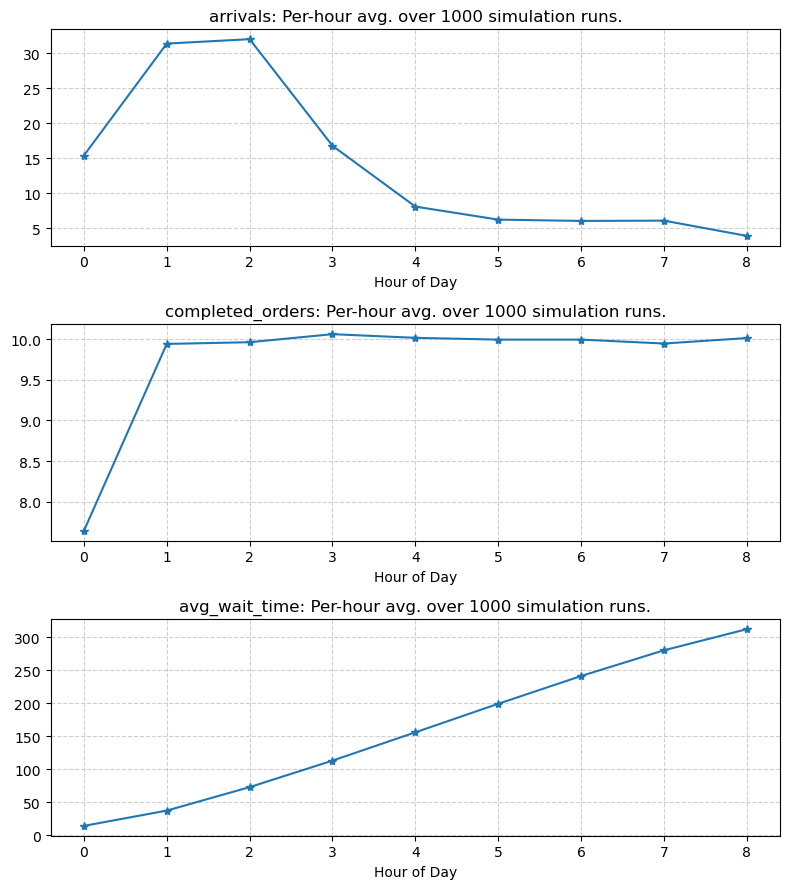

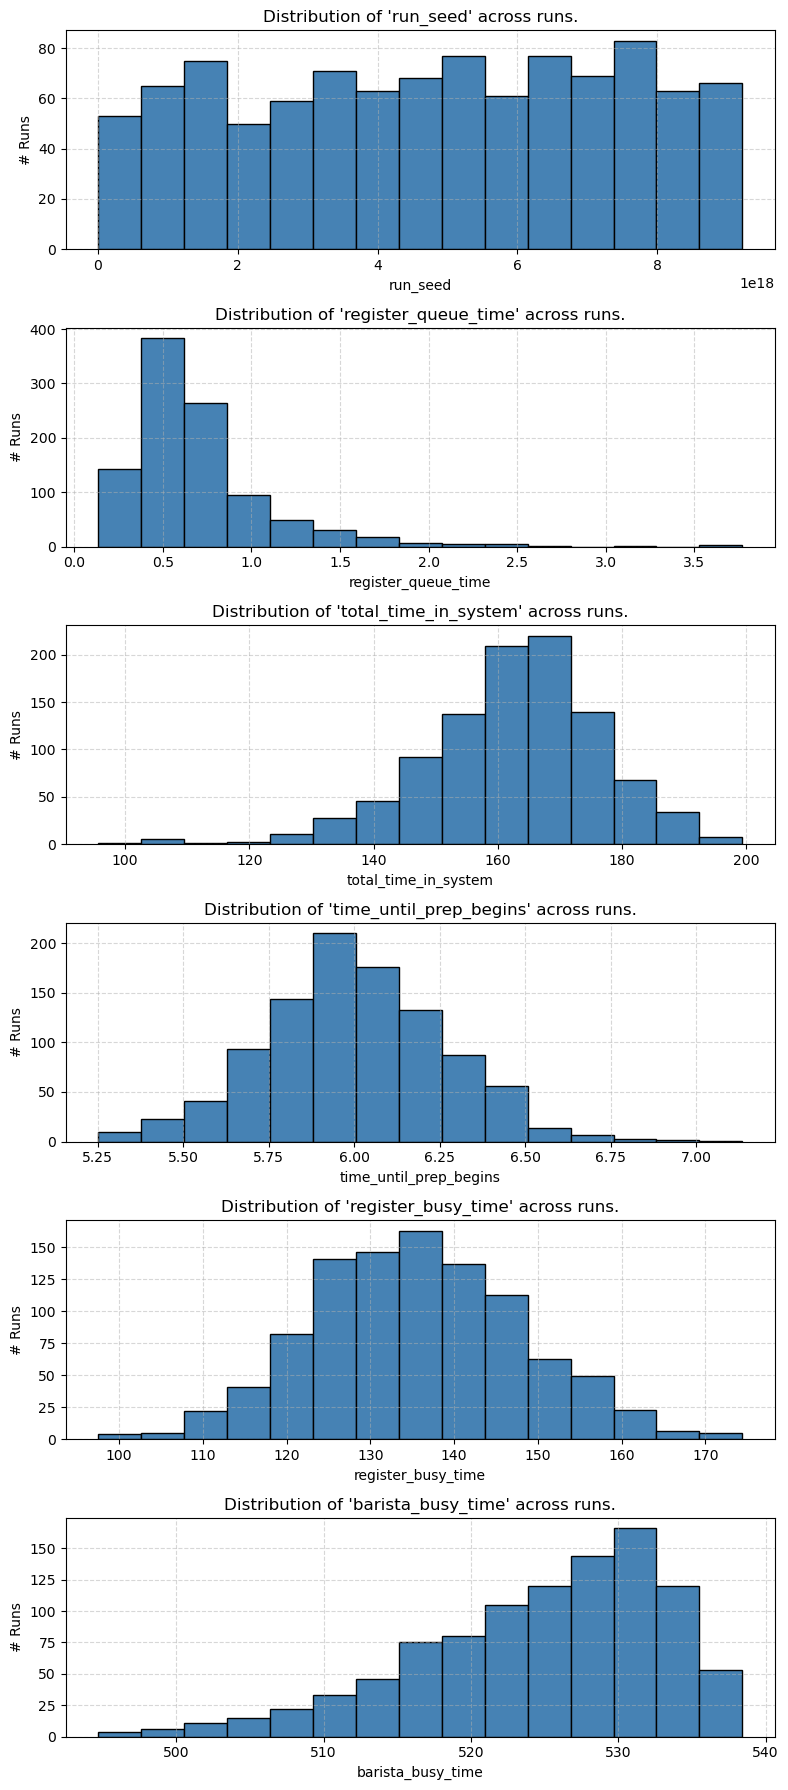

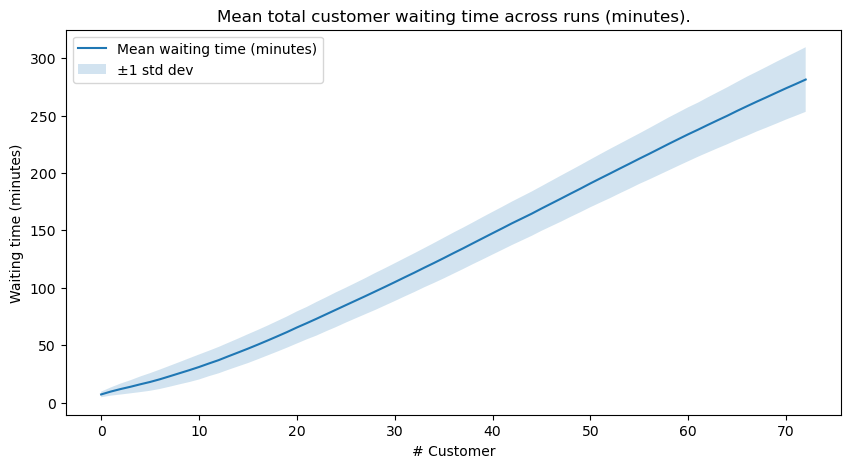

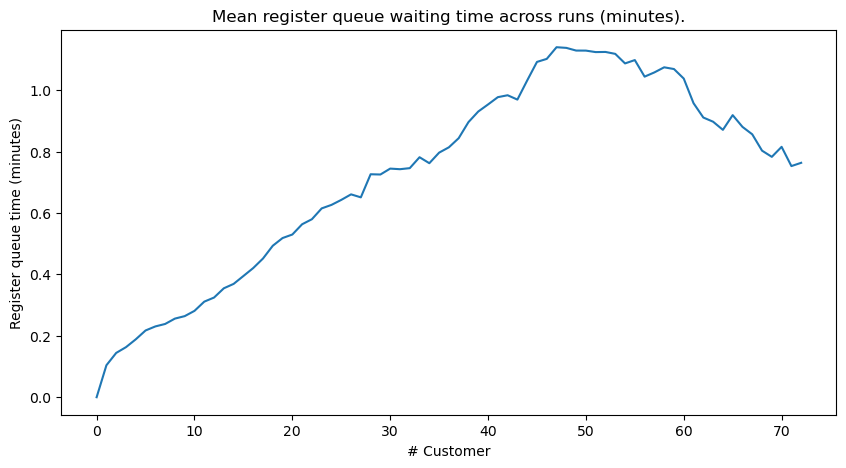

In [62]:
plot_all_multi(exp_0.results['replications'])

In this "bare minimum" situation, we can see the average total wait time rises each hour. During the rush hour, which should hit its peak at the end of hour 2, many customers should be coming in and placing their order. As they cotinue to wait for ages and ages, the total wait time only keeps piling on.

### Experiment 1: The Original Setup (Average Staffing)

The café currently has 1 register and 2 baristas working during all shifts, and has 1 coffee machine and 1 oven. We will run this to get a feel for how things usually are.

In [63]:
exp_nr      = 1
purpose     = AVERAGESTAFFED
exp_1       = run_experiment(
                exp_nr=exp_nr, 
                purpose=purpose, 
                experiments_list=all_experiments, 
                alpha=wait_weight,
                beta=utilization_weight,
                confidence=confidence,
                adjust_machines=False       # Not adding machines since this is the base case.
            )

Let's take a look at the results of those runs.

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment 2: High Staffing

[Explain params of experiment, purpose of experiment,]

In [64]:
exp_nr      = 2
purpose     = HIGHSTAFFED
exp_2       = run_experiment(
                exp_nr=exp_nr, 
                purpose=purpose, 
                experiments_list=all_experiments, 
                alpha=wait_weight,
                beta=utilization_weight,
                confidence=confidence,
                adjust_machines=True
            )


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               2 |    2 |   15.056 |                  0.439 |      0.550 |
|               2 |    1 |   15.440 |                  0.441 |      0.546 |
|               3 |    1 |   15.449 |                  0.440 |      0.488 |
|               1 |    1 |   17.454 |                  0.450 |      0.450 |
|               1 |    2 |   17.247 |                  0.449 |      0.437 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '2' coffee machines and '2' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


Let's take a look at the results of those runs.

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment 3: Full Staffing V1

[Explain params of experiment, purpose of experiment,]

In [65]:
exp_nr      = 3
purpose     = FULLSTAFFED_1
exp_3       = run_experiment(
                exp_nr=exp_nr, 
                purpose=purpose, 
                experiments_list=all_experiments, 
                alpha=wait_weight,
                beta=utilization_weight,
                confidence=confidence,
                adjust_machines=True
            )


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               2 |    2 |   15.042 |                  0.416 |      0.550 |
|               3 |    1 |   15.509 |                  0.419 |      0.546 |
|               2 |    1 |   15.417 |                  0.418 |      0.520 |
|               1 |    1 |   17.658 |                  0.429 |      0.450 |
|               1 |    2 |   17.437 |                  0.427 |      0.413 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '2' coffee machines and '2' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


Let's take a look at the results of those runs.

[This is where we'd talk about the results, discuss what's on the graphs and such]. 

### Experiment #4: Full Staffing V2

In this experiment, there will be full staffing during the rush hour period and a standard amount of staffing at other times. In particular, 1 register and 4 baristas will be present at rush hour in this experiment.

In [66]:
exp_nr      = 4
purpose     = FULLSTAFFED_2
exp_4       = run_experiment(
                exp_nr=exp_nr, 
                purpose=purpose, 
                experiments_list=all_experiments, 
                alpha=wait_weight,
                beta=utilization_weight,
                confidence=confidence,
                adjust_machines=True
            )


| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| Number of coffee machines and ovens, ranked by optimality for staffing. |
| - - - - - - - - | - - - | - - - - - | - - - - - - - - - - - - | - - - - |
| coffee machines | ovens | mean wait | mean staff utilization  |  score  |
|               2 |    1 |    9.804 |                  0.414 |      0.562 |
|               2 |    2 |    9.592 |                  0.410 |      0.550 |
|               3 |    1 |    9.754 |                  0.413 |      0.549 |
|               1 |    2 |   10.430 |                  0.421 |      0.495 |
|               1 |    1 |   10.563 |                  0.422 |      0.450 |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |
| The optimal amount of machines for this staffing configuration is:      |
| - '2' coffee machines and '1' ovens.					  |
| - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - |


### Comparing all experiments

Now that each experiment has been run, we will compare them all and put into a table.

In [67]:
for exp in all_experiments:
    compute_experiment_metrics(
        exp=exp,
        alpha=wait_weight,
        beta=utilization_weight,
        confidence=confidence
    )

In [68]:
compare_experiments = all_experiments[2:]   # Cutting out the first two experiments, since they're not serious considerations.
                                            # TODO: This is a quick fix, if we have time I should implement a more robust normalization (percentiles)
                                            # Something like min_wait = np.percentile(wait_list, 5), I think

ranked = compare_all(
    experiments=compare_experiments, 
    alpha=wait_weight,
    beta=utilization_weight,
    epsilon=epsilon,
    print_comparison=True
)
most_successful_exp_ID = ranked[0]["ID"]
most_successful_experiment = next(exp for exp in compare_experiments if (exp.ID == most_successful_exp_ID))
print_the_winner(most_successful_experiment)

--------------------------------------------------
Experiment 4
mean_wait: 9.80380895001328
mean_staff_utilization: 0.413734242287607
	- mean_register_utilization: 0.25133656750836614
	- mean_barista_utilization: 0.576131917066848
--------------------------------------------------
Experiment 2
mean_wait: 15.056100904321566
mean_staff_utilization: 0.43910364977066085
	- mean_register_utilization: 0.25030302677565996
	- mean_barista_utilization: 0.6279042727656617
--------------------------------------------------
Experiment 3
mean_wait: 15.041802654567714
mean_staff_utilization: 0.41629742238163486
	- mean_register_utilization: 0.20477468336632365
	- mean_barista_utilization: 0.6278201613969461
--------------------------------------------------

The most successful experiment was experiment nr. 4.

It had the following schedule:
HOUR:  |   1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   9    |
SHIFT: | [1, 2] | [1, 4] | [1, 4] | [1, 2] | [1, 2] | [1, 2] | [1, 2] 

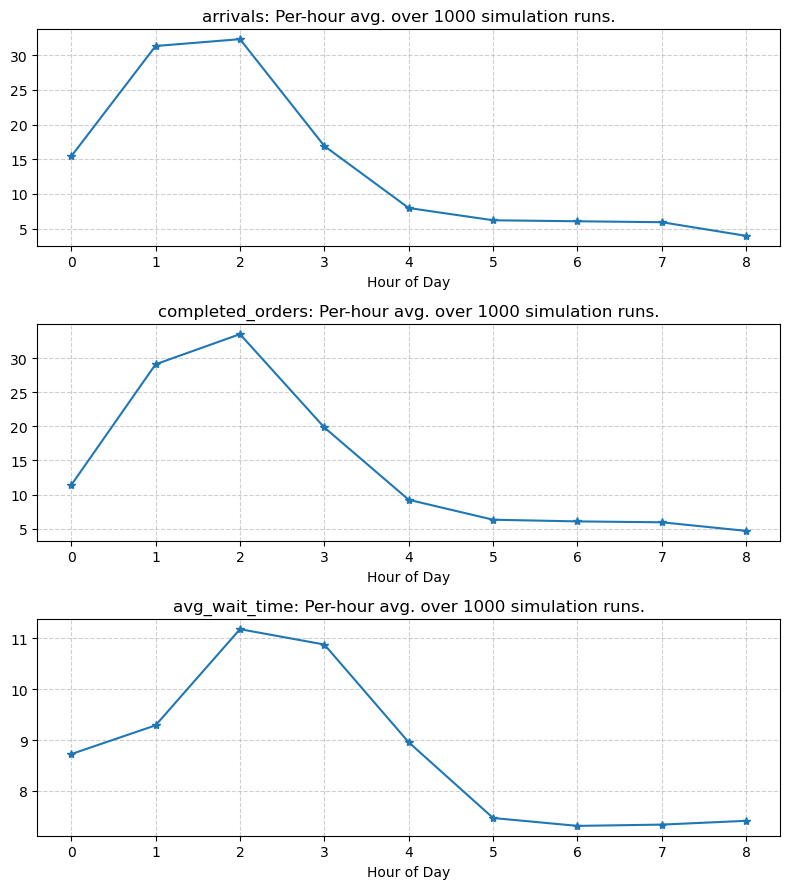

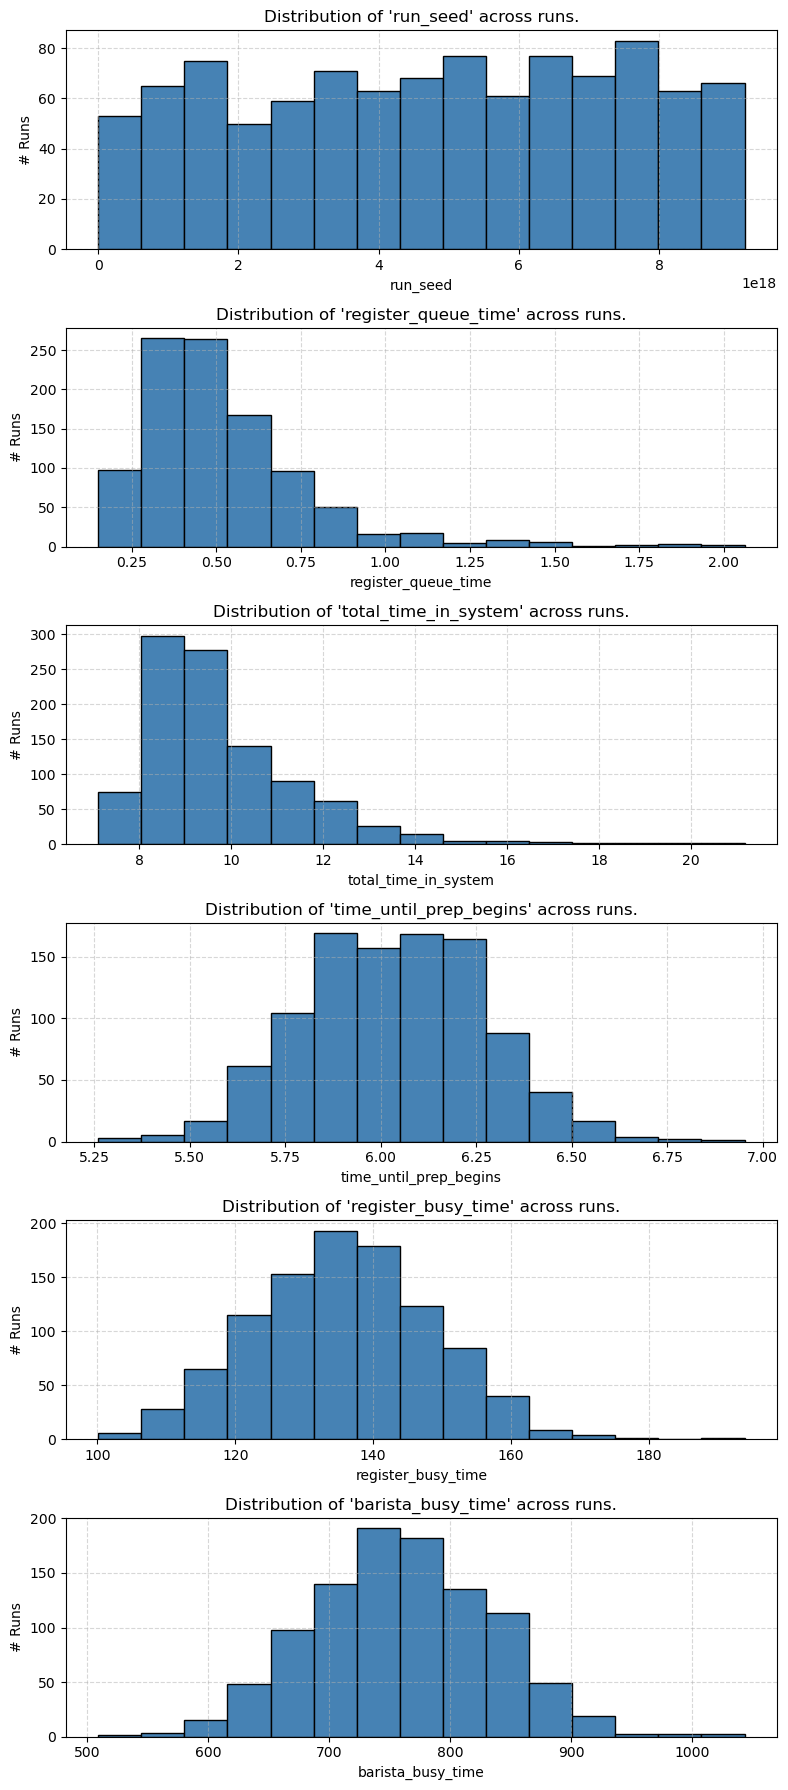

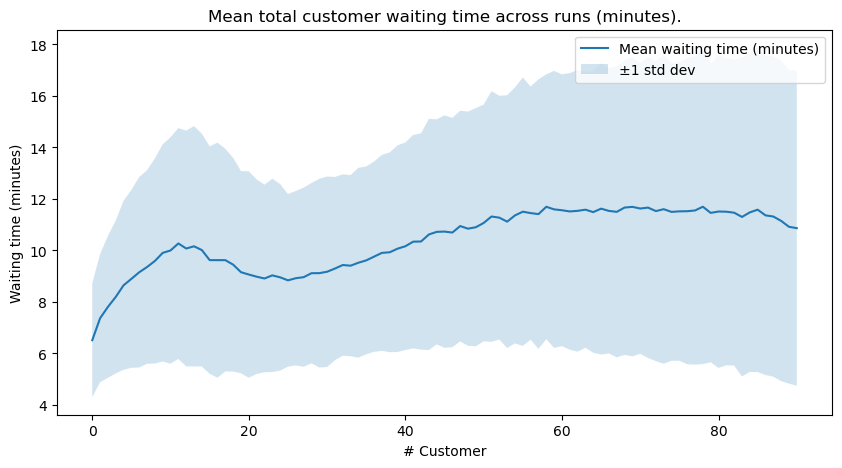

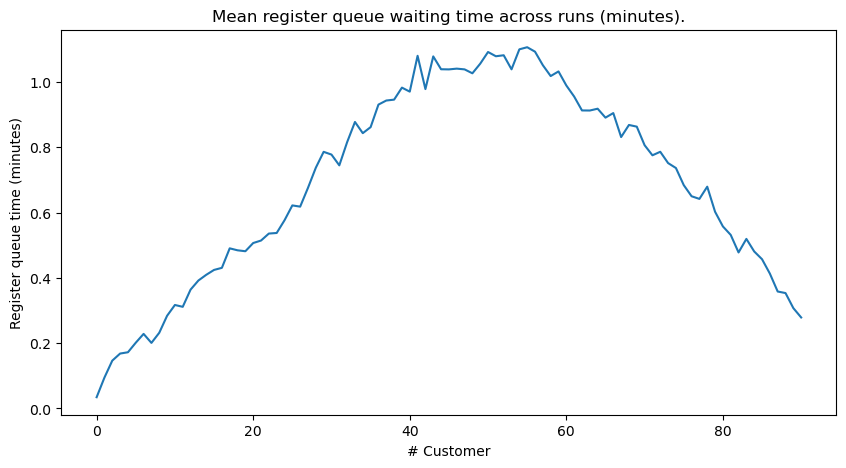

In [69]:
plot_all_multi(most_successful_experiment.results['replications'])

Blah blah blah TODO: we say something about this. Analysis.

## Discussion of results

asdfghjklkjhgfdsdfghjkl

* I assume we'll add some ways to mathematically compare results, maybe make some nice graphs, talk about the differences.
* Explain where the bottleneck was, and how the best solution out of all of these fixes things.
* Et cetera.